## Preprocessing data

In [1]:
from lib.postprocessing import postprocessing 
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import numpy as np
import nibabel as nib
from itertools import chain
import pandas as pd
from scipy.stats import ks_2samp

In [2]:
data_dir = '/Users/egermani/Documents/hcp_multi_pipeline/derivatives/spm*/node-L1/sub-*/*'
output_dir = '/Users/egermani/Documents/hcp_multi_pipeline/no-scaling'

#postprocessing(data_dir, output_dir)

## Comparing data before and after preprocessing

In [3]:
init_data = sorted(glob('/Users/egermani/Documents/hcp_multi_pipeline/derivatives/*/node-L1/sub-*/*righthand*effect*'))

In [4]:
postproc_data = sorted(glob('/Users/egermani/Documents/hcp_multi_pipeline/no-scaling/postprocessed/*/node-L1/sub-*/*righthand*effect*'))

In [5]:
assert(len(init_data) == len(postproc_data))

In [11]:
pipeline_list = ['fsl-5-0-0', 'fsl-5-0-1', 'fsl-8-0-0', 'fsl-8-0-1', 'fsl-5-6-0', 'fsl-5-6-1', 
                 'fsl-8-6-0', 'fsl-8-6-1', 'fsl-5-24-0', 'fsl-5-24-1', 'fsl-8-24-0', 'fsl-8-24-1',
                 #'spm-5-0-0', 'spm-5-0-1', 'spm-8-0-0', 'spm-8-0-1', 'spm-5-6-0', 'spm-5-6-1',
                 #'spm-8-6-0', 'spm-8-6-1', 'spm-5-24-0', 'spm-5-24-1', 'spm-8-24-0', 'spm-8-24-1'
                ]

In [12]:
def get_stat_values(img):
    '''
    Calculate the distribution of statistical values inside the data 
    '''
    
    data = img.get_fdata().copy()
    
    # Vectorise input data
    data = np.reshape(data, -1)
    
    in_mask_indices = np.logical_not(
        np.logical_or(
            np.isnan(data), np.absolute(data) == 0)
    )
    
    stat_values = data[in_mask_indices] 
        
    return stat_values

fsl-5-0-0


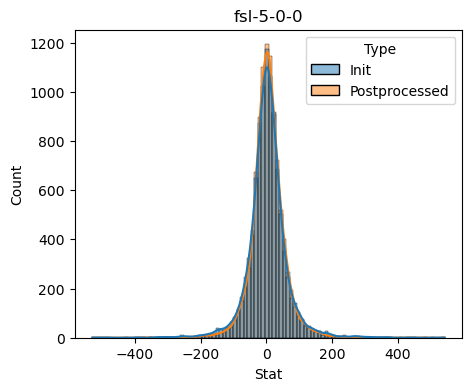

KstestResult(statistic=0.0285, pvalue=0.0005931599389177483, statistic_location=-28.54474449157715, statistic_sign=1)
fsl-5-0-1


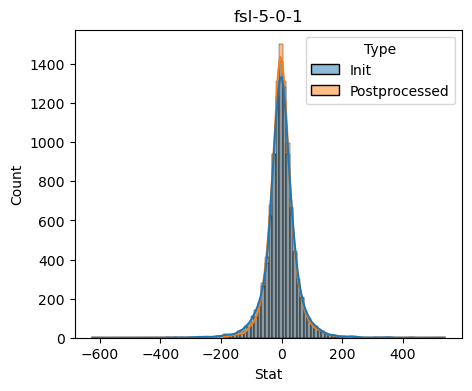

KstestResult(statistic=0.0233, pvalue=0.008773910153826243, statistic_location=-63.905364990234375, statistic_sign=1)
fsl-8-0-0


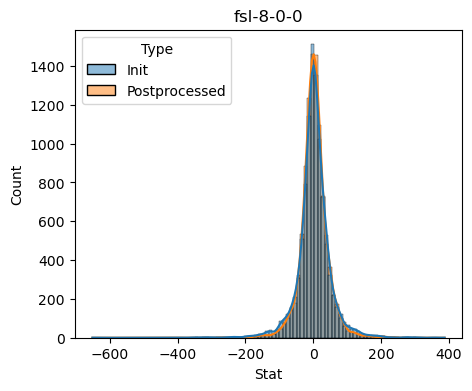

KstestResult(statistic=0.0245, pvalue=0.004943640510915934, statistic_location=-49.64335250854492, statistic_sign=1)
fsl-8-0-1


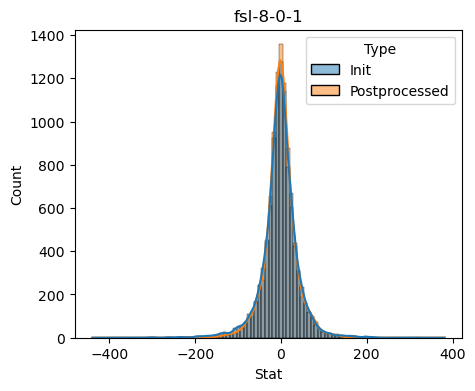

KstestResult(statistic=0.0241, pvalue=0.006004628256311834, statistic_location=-36.66997528076172, statistic_sign=1)
fsl-5-6-0


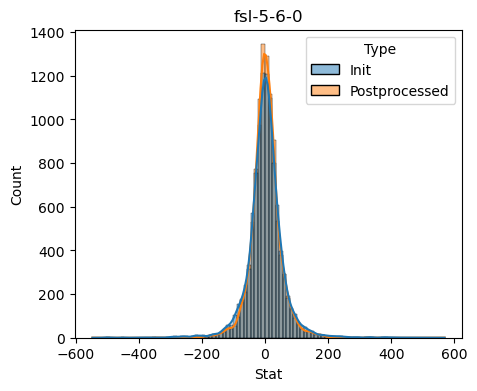

KstestResult(statistic=0.0297, pvalue=0.0002949782724904383, statistic_location=-30.099491119384766, statistic_sign=1)
fsl-5-6-1


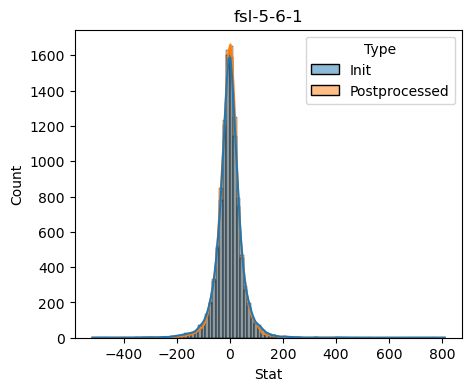

KstestResult(statistic=0.0153, pvalue=0.19231550503923178, statistic_location=-46.559410095214844, statistic_sign=1)
fsl-8-6-0


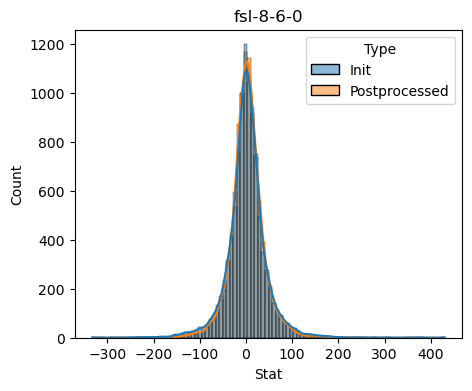

KstestResult(statistic=0.0237, pvalue=0.007270007928200741, statistic_location=-29.077396392822266, statistic_sign=1)
fsl-8-6-1


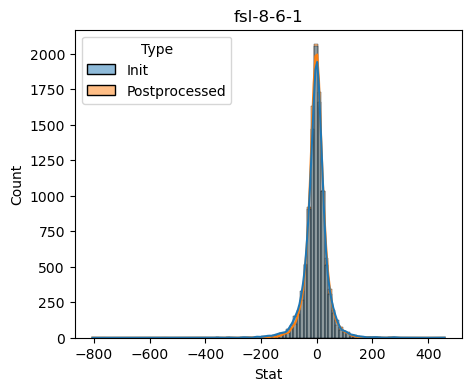

KstestResult(statistic=0.0305, pvalue=0.0001822137142750581, statistic_location=-25.17160415649414, statistic_sign=1)
fsl-5-24-0


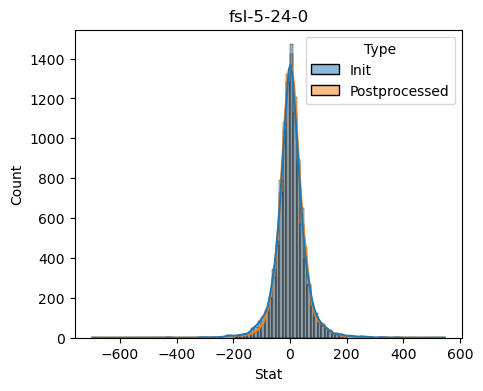

KstestResult(statistic=0.0248, pvalue=0.004263879566111113, statistic_location=-38.436439514160156, statistic_sign=1)
fsl-5-24-1


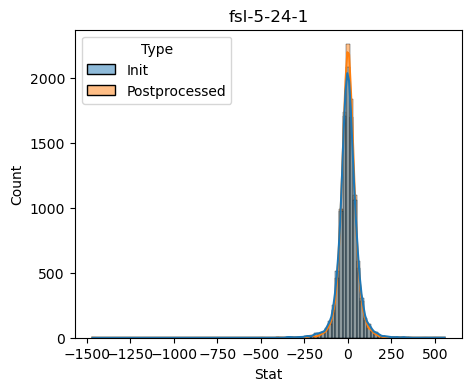

KstestResult(statistic=0.0242, pvalue=0.005721457465925187, statistic_location=-20.6709041595459, statistic_sign=1)
fsl-8-24-0


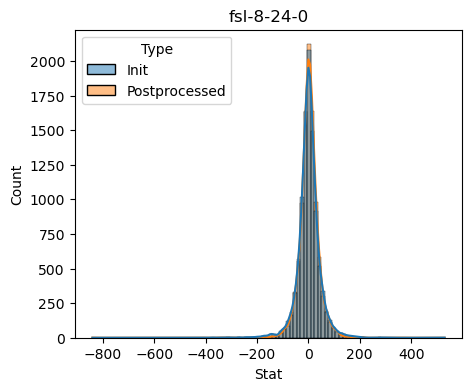

KstestResult(statistic=0.0233, pvalue=0.008773910153826243, statistic_location=-3.92266845703125, statistic_sign=1)
fsl-8-24-1


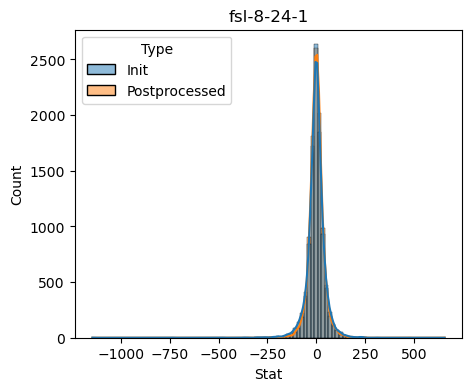

KstestResult(statistic=0.025, pvalue=0.0038596010962783566, statistic_location=-41.96039962768555, statistic_sign=1)


In [13]:
# Check with non re-scaled data
for pipeline in pipeline_list:
    print(pipeline)
    init_data_pipe = [nib.load(fpath) for fpath in init_data if pipeline in fpath]
    assert(len(init_data_pipe) == 1080)
    postproc_data_pipe = [nib.load(fpath) for fpath in postproc_data if pipeline in fpath]
    assert(len(init_data_pipe) == 1080)

    init_stat_val = [get_stat_values(img) for img in init_data_pipe]
    postproc_stat_val = [get_stat_values(img) for img in postproc_data_pipe]

    f,ax = plt.subplots(1,1, figsize=(5,4))
    stat_val_init = list(chain(*init_stat_val))
    stat_val_postproc = list(chain(*postproc_stat_val))
    
    rand_stat_val_init = np.random.choice(stat_val_init, 10000, replace=False)
    rand_stat_val_postproc = np.random.choice(stat_val_postproc, 10000, replace=False)
    
    df_init = pd.DataFrame({'Stat':rand_stat_val_init, 
                            'Type':['Init' for i in range(len(rand_stat_val_init))]})
    df_post = pd.DataFrame({'Stat':rand_stat_val_postproc, 
                            'Type':['Postprocessed' for i in range(len(rand_stat_val_postproc))]})
    
    df = pd.concat([df_init, df_post])
    
    sns.histplot(df, x='Stat', hue='Type', ax=ax, bins=100, kde=True)
    ax.set_title(f'{pipeline}')
    #ax.set_xlim([-500,500])
    plt.savefig(f'../figures/stat-distrib-init-postproc-{pipeline}.png')
    plt.show()

    print(ks_2samp(rand_stat_val_init, rand_stat_val_postproc))

## Evaluation of intra-subject between-pipeline variability

In [3]:
sub_list = np.unique([f.split('/')[-1] for f \
            in glob('/Users/egermani/Documents/hcp_multi_pipeline/postprocessed/fsl-5-0-0/node-L1/sub-*')])

In [4]:
def get_mean_var_voxel_map(img_list):
    data_img_list = np.array([nib.load(img).get_fdata() for img in img_list])
    mean_voxel_data = np.mean(data_img_list, axis=0)
    var_voxel_data = np.var(data_img_list, axis=0)

    mean_voxel_map = nib.Nifti1Image(mean_voxel_data, affine = nib.load(img_list[0]).affine)
    var_voxel_map = nib.Nifti1Image(var_voxel_data, affine = nib.load(img_list[0]).affine)

    return mean_voxel_map, var_voxel_map

In [5]:
mean_img_list_bw_pipe = []
var_img_list_bw_pipe = []

for sub in sub_list:
    postproc_data_per_sub = sorted(glob(f'/Users/egermani/Documents/hcp_multi_pipeline/postprocessed/*/node-L1/{sub}/*'))
    mean_img, var_img = get_mean_var_voxel_map(postproc_data_per_sub)
    mean_img_list_bw_pipe.append(mean_img)
    var_img_list_bw_pipe.append(var_img)

In [6]:
from nilearn import plotting, image
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

mean_variance_map = image.mean_img(var_img_list_bw_pipe)

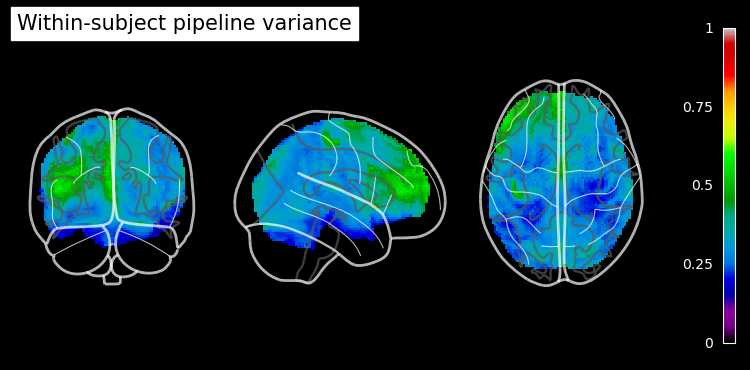

In [14]:
plotting.plot_glass_brain(image.math_img(formula = 'np.sqrt(img)', img=mean_variance_map), #display_mode = 'z', 
                  cmap=plt.get_cmap('nipy_spectral'), bg_img=None, vmax=1,
                  colorbar=True, draw_cross=False, black_bg=True, threshold=None,
                  annotate=False, title='Within-subject pipeline variance')
plt.savefig('../figures/within-sub-pipeline-var.png')

## Evaluation of between-subject variance as a function of pipeline

### Version Camille : global across pipelines

In [8]:
def get_variance_mean_map(img_list):
    var_mean_data = np.var(np.array([img.get_fdata() for img in img_list]), axis=0)
    var_voxel_map = nib.Nifti1Image(var_mean_data, affine = img_list[0].affine)

    return var_voxel_map

In [9]:
var_mean_map = get_variance_mean_map(mean_img_list_bw_pipe)

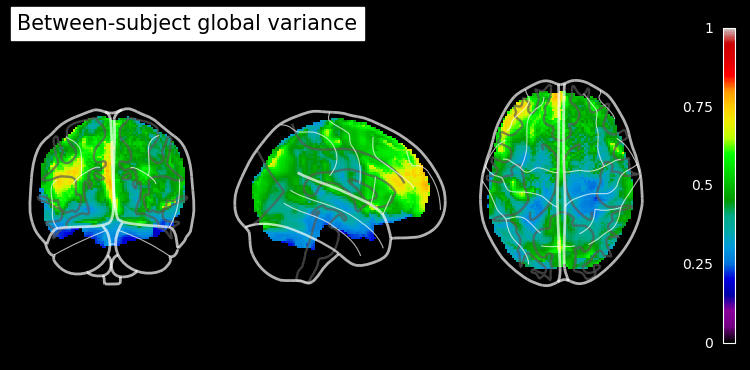

In [15]:
plotting.plot_glass_brain(image.math_img(formula = 'np.sqrt(img)', img=var_mean_map),  
                  cmap=plt.get_cmap('nipy_spectral'), bg_img=None, vmax=1,
                  colorbar=True, draw_cross=False, black_bg=True, threshold=None,
                  annotate=False, title='Between-subject global variance')
plt.savefig('../figures/between-sub-var.png')

### Elodie's version : bw-subject variance for each pipeline

In [ ]:
mean_img_list_bw_sub = []
var_img_list_bw_sub = []

for pipe in pipeline_list:
    postproc_data_per_pipe = sorted(glob(f'/Users/egermani/Documents/hcp_multi_pipeline/postprocessed/{pipe}/node-L1/*/*'))
    mean_img, var_img = get_mean_var_voxel_map(postproc_data_per_pipe)
    
    mean_img_list_bw_sub.append(mean_img)
    var_img_list_bw_sub.append(var_img)

In [ ]:
for i,var_img in enumerate(var_img_list_bw_sub):
    f, ax = plt.subplots(1,1, figsize=(8, 3))
    plotting.plot_glass_brain(image.math_img(formula = 'np.sqrt(img)', img=var_img),  
                  cmap=plt.get_cmap('nipy_spectral'), bg_img=None, figure=f, axes=ax,
                  colorbar=True, draw_cross=False, black_bg=True, threshold=None, vmax=1.5, vmin=0,
                  annotate=False, title = pipeline_list[i])
    f.tight_layout()
    plt.savefig(f'../figures/between-sub-pipeline-{pipeline_list[i]}-var.png')